In [1]:
import pandas as pd
import numpy as np
from deeplift.visualization import viz_sequence
from pyfaidx import Fasta
from tqdm import tqdm

from get_gradients import load_sequence

MERGED_EQTL_TSV_PATH = "../merged_eqtl_results.tsv"
FASTA_PATH = "/data/yosef3/scratch/ruchir/data/genomes/hg38/hg38.fa"
SEQLEN = 131072

2023-12-13 15:37:50.489932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 15:37:51.982782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def encode_one_hot(seq: str) -> np.ndarray:
    assert len(seq) == SEQLEN
    seq_one_hot = np.zeros((len(seq), 4), dtype=np.int32)
    for i, nt in enumerate(seq):
        if nt == "A":
            seq_one_hot[i, 0] = 1
        elif nt == "C":
            seq_one_hot[i, 1] = 1
        elif nt == "G":
            seq_one_hot[i, 2] = 1
        elif nt == "T":
            seq_one_hot[i, 3] = 1
    return seq_one_hot


def get_input_by_gradients(replicate_gradients_path: str, central_bps: int = 51) -> np.ndarray:
    replicate_gradients = np.load(replicate_gradients_path)
    variants = replicate_gradients["variants"]
    gradients = replicate_gradients["grads"]
    assert variants.shape[0] == gradients.shape[0]

    fasta = Fasta(FASTA_PATH)

    input_by_gradients = []
    seqs = []

    for i in tqdm(range(variants.size)):
        variant = variants[i]
        gradient = gradients[i]
        assert gradient.shape == (SEQLEN, 4)
        gradient = gradient - np.mean(gradient, axis=1)[:, np.newaxis]

        sequence = load_sequence(variant, fasta, SEQLEN)
        sequence_one_hot = encode_one_hot(sequence)
        input_by_gradient = np.sum(gradient * sequence_one_hot, axis=1)
        assert input_by_gradient.shape == (SEQLEN,)
        
        variant_idx = SEQLEN // 2
        _, _, variant_ref, _ , _ = variant.split("_")
        assert variant_ref == sequence[variant_idx]
        center_start = variant_idx - central_bps // 2
        center_end = center_start + central_bps
        
        input_by_gradients.append(input_by_gradient[center_start: center_end])
        seqs.append(sequence[center_start: center_end])
    
    input_by_gradients = np.array(input_by_gradients)
    seqs = np.array(seqs)
    return variants, input_by_gradients, seqs


def get_gradients(replicate_gradients_path: str, central_bps: int = 51):
    print(f"Loading gradients at {replicate_gradients_path}")
    replicate_gradients = np.load(replicate_gradients_path)
    variants = replicate_gradients["variants"]
    gradients = replicate_gradients["grads"]

    assert variants.shape[0] == gradients.shape[0]
    assert gradients.shape[1] == SEQLEN

    variant_idx = SEQLEN // 2
    center_start = variant_idx - central_bps // 2
    center_end = center_start + central_bps

    gradients = gradients - np.mean(gradients, axis=2)[:, :, np.newaxis]
    center_gradients = gradients[:, center_start: center_end, :]
    return variants, center_gradients

In [24]:
rep1_variants, rep1_input_by_gradients, rep1_seqs = get_input_by_gradients("rep1.npz")
rep2_variants,rep2_input_by_gradients, rep2_seqs = get_input_by_gradients("rep2.npz")
rep3_variants, rep3_input_by_gradients, rep3_seqs = get_input_by_gradients("rep3.npz")

100%|██████████| 8545/8545 [06:10<00:00, 23.08it/s]


In [5]:
rep1_variants, rep1_gradients = get_gradients("rep1.npz")
rep2_variants, rep2_gradients = get_gradients("rep2.npz")
rep3_variants, rep3_gradients = get_gradients("rep3.npz")

Loading gradients at rep1.npz
Loading gradients at rep2.npz
Loading gradients at rep3.npz


In [7]:
def visualize_input_by_gradients(input_by_gradients: np.ndarray, seq: str):
    weights = np.zeros((len(seq), 4))
    for i, nt in enumerate(seq):
        if nt == "A":
            weights[i, 0] = input_by_gradients[i]
        elif nt == "C":
            weights[i, 1] = input_by_gradients[i]
        elif nt == "G":
            weights[i, 2] = input_by_gradients[i]
        elif nt == "T":
            weights[i, 3] = input_by_gradients[i]
    
    highlight_start = len(seq) // 2
    highlight_end = highlight_start + 1
    viz_sequence.plot_weights(weights, highlight={"black": [(highlight_start, highlight_end)]})

def visualize_gradients(gradients: np.ndarray):
    assert gradients.ndim == 2
    assert gradients.shape[1] == 4
    highlight_start = gradients.shape[0] // 2
    highlight_end = highlight_start + 1
    viz_sequence.plot_weights(gradients, highlight={"black": [(highlight_start, highlight_end)]})

In [31]:
print(rep1_variants[2], rep2_variants[2], rep3_variants[2])

chr10_101037502_C_T_b38 chr10_101037502_C_T_b38 chr10_101037502_C_T_b38


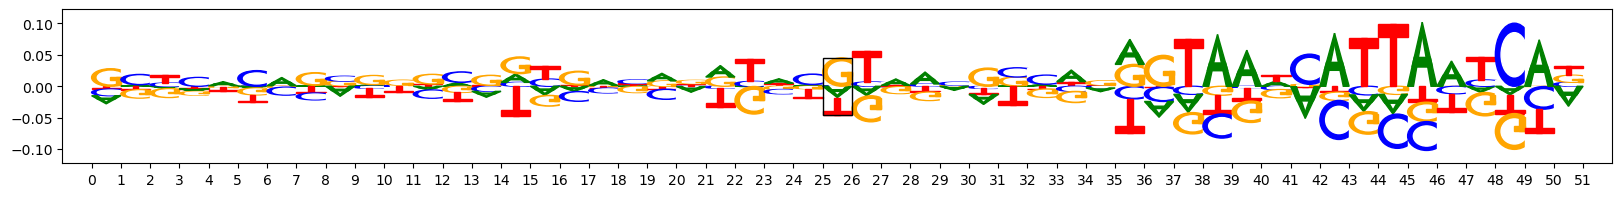

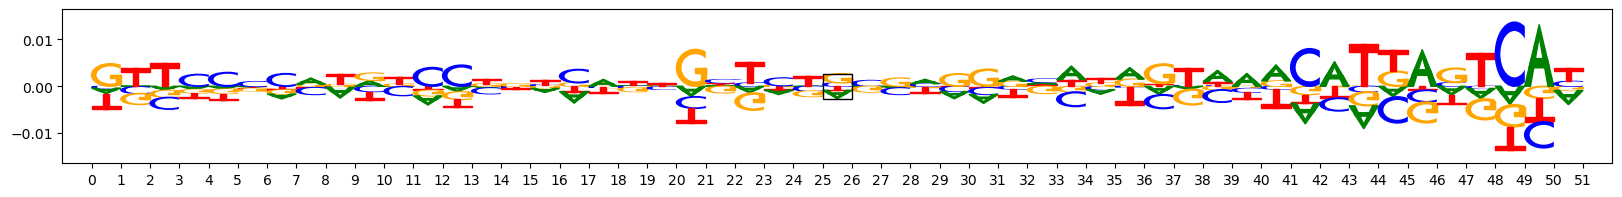

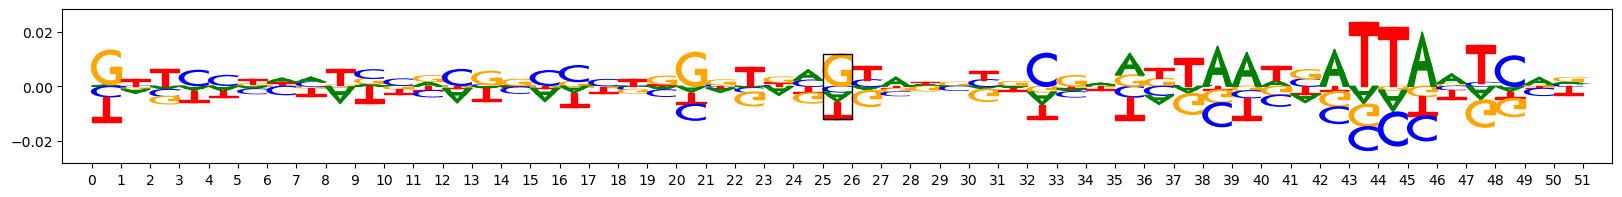

In [40]:
visualize_gradients(rep1_gradients[4])
visualize_gradients(rep2_gradients[4])
visualize_gradients(rep3_gradients[4])

In [16]:
merged_eqtl_df = pd.read_csv(MERGED_EQTL_TSV_PATH, sep="\t", index_col=0)
merged_eqtl_df = merged_eqtl_df[merged_eqtl_df["finemapped"]].copy()

In [42]:
merged_eqtl_df.iloc[4][["variant", "CAGE_SAD_1", "CAGE_SAD_2", "CAGE_SAD_3", "n_correct_CAGE_SAD", "beta_marginal", "beta_posterior"]]

variant               chr10_102876898_G_C_b38
CAGE_SAD_1                           0.013855
CAGE_SAD_2                           0.002014
CAGE_SAD_3                           0.000305
n_correct_CAGE_SAD                          5
beta_marginal                        0.911395
beta_posterior                       0.906585
Name: 115039, dtype: object

In [24]:
merged_eqtl_df

,chromosome,start,end,variant,allele1,allele2,minor_allele,tissue,gene,maf,beta_marginal,se_marginal,z,pip,cs_id,beta_posterior,sd_posterior,snp,variant_hg19,finemapped,TSS_dist,CAGE_SAD_1,DNase_SAD_1,CAGE_SAD_2,DNase_SAD_2,CAGE_SAD_3,DNase_SAD_3,CAGE_SAD_4,DNase_SAD_4,CAGE_SAD_5,DNase_SAD_5,n_pos_CAGE_SAD,n_neg_CAGE_SAD,n_agree_CAGE_SAD,n_correct_CAGE_SAD,n_pos_DNase_SAD,n_neg_DNase_SAD,n_agree_DNase_SAD,n_correct_DNase_SAD
114591,chr10,101031041,101031042,chr10_101031042_C_A_b38,C,A,A,Pancreas,ENSG00000186862.17,0.324590,-0.419588,0.067638,-6.203399,0.996814,1,-0.407405,0.070417,True,chr10_102790799_C_A,True,23206,-1.742000,0.080100,-2.273000,0.023440,-2.781000,-0.007812,-1.359000,0.263700,-1.336000,0.175800,0,5,5,5,4,1,4,1
114592,chr10,101032472,101032473,chr10_101032473_G_T_b38,G,T,T,Pancreas,ENSG00000107819.13,0.060656,0.380148,0.081564,4.660756,0.997413,2,0.405732,0.075865,True,chr10_102792230_G_T,True,1240,-1.273000,-0.011720,-1.150000,0.359400,-0.320300,0.107400,-1.145000,0.295000,-0.886700,0.214800,0,5,5,0,4,1,4,4
114593,chr10,101037501,101037502,chr10_101037502_C_T_b38,C,T,T,Pancreas,ENSG00000107819.13,0.229508,0.281704,0.047778,5.896115,0.922923,1,0.296226,0.095504,True,chr10_102797259_C_T,True,6269,-0.007080,0.000244,-0.016850,0.002197,-0.022700,-0.000244,-0.028320,-0.000488,-0.029300,0.001953,0,5,5,0,3,2,3,3
115031,chr10,102856742,102856743,chr10_102856743_T_C_b38,T,C,C,Pancreas,ENSG00000166275.15,0.232787,-0.693552,0.063104,-10.990653,0.953952,1,-0.605308,0.143720,True,chr10_104616500_T_C,True,2521,-0.000183,0.004883,0.000427,0.000122,-0.001251,0.007324,0.000580,0.007080,0.001709,0.007324,3,2,3,2,5,0,5,0
115039,chr10,102876897,102876898,chr10_102876898_G_C_b38,G,C,C,Pancreas,ENSG00000214435.7,0.142623,0.911395,0.064514,14.127132,0.999715,1,0.906585,0.066035,True,chr10_104636655_G_C,True,7383,0.013855,0.028080,0.002014,0.011230,0.000305,0.011720,0.011410,0.016480,0.014770,0.072270,5,0,5,5,5,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93141,chrX,14893906,14893907,chrX_14893907_C_T_b38,C,T,C,Cells_EBV-transformed_lymphocytes,ENSG00000130150.11,0.336735,-0.664007,0.049976,-13.286518,0.999918,1,-0.660217,0.050021,True,chrX_14912029_C_T,True,20467,-0.015630,-0.005860,-0.023440,-0.005370,0.002930,-0.001831,-0.011720,-0.003418,0.002930,-0.001343,2,3,3,3,0,5,5,5
94973,chrX,149527011,149527012,chrX_149527012_G_T_b38,G,T,G,Cells_EBV-transformed_lymphocytes,ENSG00000238039.1,0.282313,-0.847742,0.071354,-11.880858,0.999994,1,-0.841772,0.070889,True,chrX_148608551_T_G,True,15504,-0.008790,-0.001465,-0.013670,0.004150,-0.029300,0.000122,-0.063500,0.001099,0.007812,-0.000610,1,4,4,4,3,2,3,2
92840,chrX,1614998,1614999,chrX_1614999_G_C_b38,G,C,C,Cells_EBV-transformed_lymphocytes,ENSG00000196433.12,0.353741,0.865277,0.109592,7.895439,1.000000,1,0.851491,0.108344,True,chrX_1733892_G_C,True,1,-0.008790,0.004272,-0.063500,0.003906,-0.087900,0.002808,0.057620,0.010010,-0.096200,0.007690,1,4,4,1,5,0,5,5
92905,chrX,2615839,2615840,chrX_2615840_C_G_b38,C,G,G,Cells_EBV-transformed_lymphocytes,ENSG00000230542.6,0.346939,-0.609499,0.077297,-7.885127,1.000000,1,-0.599763,0.076416,True,chrX_2533881_C_G,True,2853,-0.074200,0.015630,0.363300,0.011230,1.062500,-0.011230,0.785000,0.001709,0.396500,0.001953,4,1,4,1,4,1,4,1
